## Imports

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

## Data Preparations

### 1. Load data files

In [3]:
# load the data from keras datasets
fashion_mnist = tf.keras.datasets.fashion_mnist
# divide the data into train and test
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data() 

4422102/4422102 [==============================] - 0s 0us/step


### 1.1 Describe the data

In [4]:
# shape of train data
print('The train data has', X_train.shape[0], 'examples with shape', X_train.shape[1:])

The train data has 60000 examples with shape (28, 28)


In [5]:
# shape of test data
print('The test data has', X_test.shape[0], 'examples with shape', X_test.shape[1:])

The test data has 10000 examples with shape (28, 28)


In [6]:
classes_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
unique_labels = np.unique(y_train)
labels_dict = {classes_names[i]: unique_labels[i] for i in range(len(unique_labels))}
for class_name, label in labels_dict.items():
    print('The label', label, 'represents a class that is', class_name)

The label 0 represents a class that is T-shirt/top
The label 1 represents a class that is Trouser
The label 2 represents a class that is Pullover
The label 3 represents a class that is Dress
The label 4 represents a class that is Coat
The label 5 represents a class that is Sandal
The label 6 represents a class that is Shirt
The label 7 represents a class that is Sneaker
The label 8 represents a class that is Bag
The label 9 represents a class that is Ankle boot


### 1.5 Draw some of the images

Some of the images from fashion-MNIST:


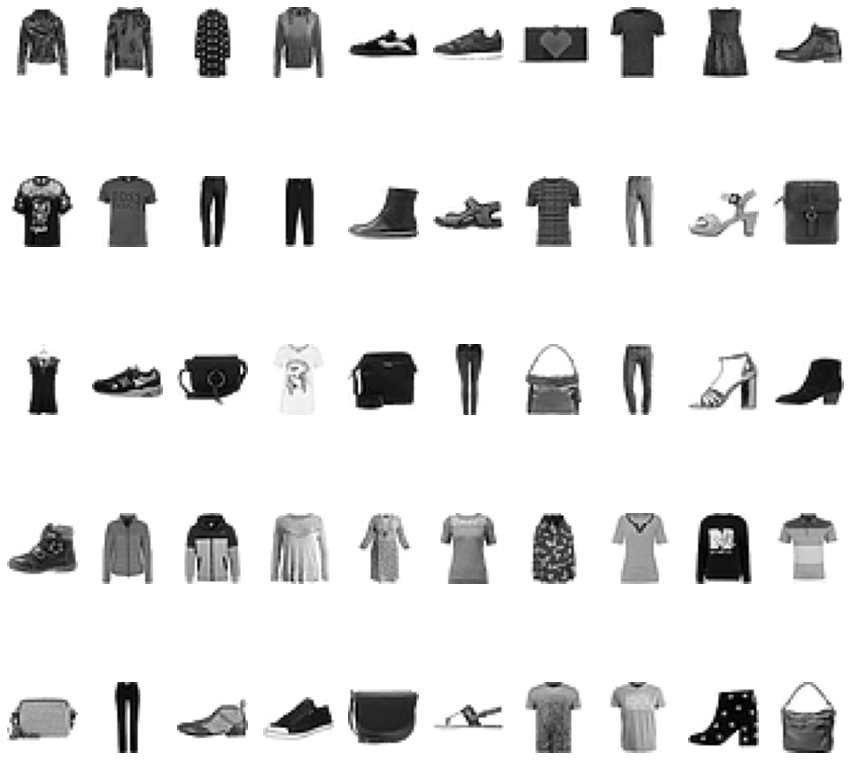

In [7]:
def draw_images(data, num_of_images):
    '''
    This function draws a random images from the data, by specifying how many images to draw
    '''
    random_indexes = [np.random.randint(0, len(X_train)) for i in range(num_of_images)]
    fig , axis = plt.subplots(5,10)
    fig.set_figwidth(15)
    fig.set_figheight(15)
    i , j = 0 , 0
    for idx in random_indexes:
        image = X_train[idx]
        axis[i,j].imshow(image, cmap='binary')
        axis[i,j].axis('off')
        j += 1
        if j % 10 == 0:
            i += 1
            j = 0
# draw some images
print('Some of the images from fashion-MNIST:')
draw_images(data=X_train, num_of_images=50)

### 2. Carry out required preprocessing operations on the data

In [8]:
# normalize train and test data
X_train = X_train / 255.0
X_test = X_test / 255.0
# add channel dimension for train and test data to be suitable for the CNN network
X_train = np.expand_dims(X_train,axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

### 3. Encode the labels

In [9]:
# encode train and test labels
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

## Training a CNN neural network

### Plot Function

In [13]:
def train_curves(history, special_title):
    '''
    This function draws accuracy and loss curves for each epoch between train and validation data
    '''
    title_loss = 'Model loss per epoch ' + special_title
    title_accuracy = 'Model accuracy per epoch ' + special_title
    fig , axis = plt.subplots(nrows=1, ncols=2)
    # dimensions of figure
    fig.set_figheight(6)
    fig.set_figwidth(14)
    # loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    # accuracy
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epoch = np.arange(150)
    # loss curve
    axis[0].plot(loss,label='Train')
    axis[0].plot(val_loss,label='Validation')
    axis[0].set_xlabel('epoch')
    axis[0].set_ylabel('loss')
    axis[0].set_title(title_loss)
    axis[0].legend()
    # accuracy curve
    axis[1].plot(accuracy, label='Train')
    axis[1].plot(val_accuracy, label='Validation')
    axis[1].set_xlabel('epoch')
    axis[1].set_ylabel('accuracy')
    axis[1].set_title(title_accuracy)
    axis[1].legend()

### LeNet-5 Architecture

In [10]:
def lenet_5():
    '''
    This function defines the architecure of LeNet-5
    '''
    model = Sequential([
        Input(shape=(28,28,1)),
        Conv2D(filters= 6, kernel_size=(5,5), strides=(1,1), padding='valid'),
        AveragePooling2D(pool_size = (2,2), strides = 2),
        Conv2D(filters= 16, kernel_size=(5,5), strides=(1,1), padding='valid'),
        AveragePooling2D(pool_size = (2,2), strides = 2),
        Flatten(),
        Dense(units = 120, activation='relu'),
        Dense(units = 84, activation='relu'),
        Dense(units= 10, activation='softmax')
    ])
    
    return model

In [11]:
# initialize the model and output the model summary
model = lenet_5()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 12, 12, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 4, 4, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 120)               3

In [12]:
# compile the model
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])
# Training ...
history = model.fit(x= X_train, y= y_train, epochs=25, batch_size= 256, validation_split=0.1)

Epoch 1/25
211/211 [==============================] - 10s 7ms/step - loss: 0.8533 - accuracy: 0.6980 - val_loss: 0.5966 - val_accuracy: 0.7705
Epoch 2/25
211/211 [==============================] - 1s 5ms/step - loss: 0.5539 - accuracy: 0.7979 - val_loss: 0.5048 - val_accuracy: 0.8143
Epoch 3/25
211/211 [==============================] - 1s 5ms/step - loss: 0.4811 - accuracy: 0.8249 - val_loss: 0.4517 - val_accuracy: 0.8340
Epoch 4/25
211/211 [==============================] - 1s 5ms/step - loss: 0.4351 - accuracy: 0.8418 - val_loss: 0.4476 - val_accuracy: 0.8353
Epoch 5/25
211/211 [==============================] - 1s 5ms/step - loss: 0.4079 - accuracy: 0.8519 - val_loss: 0.4147 - val_accuracy: 0.8497
Epoch 6/25
211/211 [==============================] - 1s 5ms/step - loss: 0.3851 - accuracy: 0.8599 - val_loss: 0.3932 - val_accuracy: 0.8595
Epoch 7/25
211/211 [==============================] - 2s 8ms/step - loss: 0.3677 - accuracy: 0.8655 - val_loss: 0.3870 - val_accuracy: 0.8575
Epoch

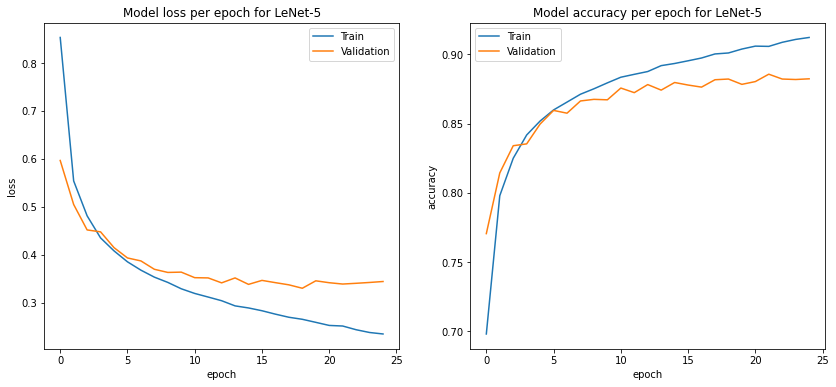

In [15]:
# visualize accuracy and loss curves
train_curves(history=history, special_title= 'for LeNet-5')